In [3]:
# Load dataset
data = np.load('dataset_dev_3000.npz')
X = data['X']
y = data['y']

print(f"Input X shape: {X.shape}")
print(f"Targets y shape: {y.shape}")
print(f"\nTarget A (10-class): range [{y[:, 0].min():.0f}, {y[:, 0].max():.0f}]")
print(f"Target B (32-class): {len(np.unique(y[:, 1]))} classes")
print(f"Target C (Regression): range [{y[:, 2].min():.4f}, {y[:, 2].max():.4f}]")

Input X shape: (3000, 32, 32)
Targets y shape: (3000, 3)

Target A (10-class): range [0, 9]
Target B (32-class): 32 classes
Target C (Regression): range [0.0003, 0.9996]


## Model 1: Single-Task Baseline CNN (Target A only)

In [6]:
# Train baseline model
print("Training baseline model...")

callbacks_baseline = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history_baseline = baseline_model.fit(
    X_train, y_train[:, 0],
    validation_data=(X_val, y_val[:, 0]),
    epochs=50,
    batch_size=64,
    callbacks=callbacks_baseline,
    verbose=2
)

# Evaluate
val_loss, val_acc = baseline_model.evaluate(X_val, y_val[:, 0], verbose=2)
print(f"\n✓ Baseline Model - Validation Accuracy: {val_acc*100:.2f}%")

Training baseline model...
Epoch 1/50
38/38 - 2s - 41ms/step - accuracy: 0.1133 - loss: 2.3078 - val_accuracy: 0.1000 - val_loss: 2.2976 - learning_rate: 0.0010
Epoch 2/50
38/38 - 1s - 14ms/step - accuracy: 0.1183 - loss: 2.2942 - val_accuracy: 0.1383 - val_loss: 2.2898 - learning_rate: 0.0010
Epoch 3/50
38/38 - 1s - 14ms/step - accuracy: 0.1396 - loss: 2.2800 - val_accuracy: 0.1683 - val_loss: 2.2444 - learning_rate: 0.0010
Epoch 4/50
38/38 - 1s - 15ms/step - accuracy: 0.1488 - loss: 2.2499 - val_accuracy: 0.1583 - val_loss: 2.2202 - learning_rate: 0.0010
Epoch 5/50
38/38 - 1s - 14ms/step - accuracy: 0.1621 - loss: 2.2326 - val_accuracy: 0.2000 - val_loss: 2.1807 - learning_rate: 0.0010
Epoch 6/50
38/38 - 1s - 14ms/step - accuracy: 0.1813 - loss: 2.1915 - val_accuracy: 0.2133 - val_loss: 2.1227 - learning_rate: 0.0010
Epoch 7/50
38/38 - 1s - 14ms/step - accuracy: 0.1863 - loss: 2.1464 - val_accuracy: 0.2517 - val_loss: 2.0605 - learning_rate: 0.0010
Epoch 8/50
38/38 - 1s - 14ms/step -

In [69]:
# Prepare data for multi-task training
X_train_mtl = X_train[..., None].astype('float32')
X_val_mtl = X_val[..., None].astype('float32')

# Normalize
mean = X_train_mtl.mean()
std = X_train_mtl.std() + 1e-6
X_train_mtl = (X_train_mtl - mean) / std
X_val_mtl = (X_val_mtl - mean) / std

# Extract targets
y_A_train, y_B_train, y_C_train = y_train[:, 0], y_train[:, 1], y_train[:, 2]
y_A_val, y_B_val, y_C_val = y_val[:, 0], y_val[:, 1], y_val[:, 2]

# print("Data prepared for multi-task learning:")
# print(f"  X_train: {X_train_mtl.shape}")
# print(f"  X_val: {X_val_mtl.shape}")
# print(f"  Target A: {y_A_train.shape} (10 classes)")
# print(f"  Target B: {y_B_train.shape} (32 classes)")
# print(f"  Target C: {y_C_train.shape} (regression [{y_C_train.min():.4f}, {y_C_train.max():.4f}])")

In [70]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf
import numpy as np


def build_hypothesis_mtl_model_v5(input_shape=(32, 32, 1)):
    inputs = layers.Input(shape=input_shape)

    def residual_block(x, filters, strides=1):
        residual = x
        x = layers.Conv2D(
            filters,
            3,
            strides=strides,
            padding="same",
            use_bias=False,
            kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(2e-4),
        )(x)
        x = layers.BatchNormalization(momentum=0.9)(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(
            filters,
            3,
            padding="same",
            use_bias=False,
            kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(2e-4),
        )(x)
        x = layers.BatchNormalization(momentum=0.9)(x)

        if strides != 1 or residual.shape[-1] != filters:
            residual = layers.Conv2D(
                filters,
                1,
                strides=strides,
                padding="same",
                kernel_initializer="he_normal",
            )(residual)
            residual = layers.BatchNormalization(momentum=0.9)(residual)

        x = layers.Add()([x, residual])
        x = layers.ReLU()(x)
        return x

    x = layers.Conv2D(
        64,
        3,
        padding="same",
        use_bias=False,
        kernel_initializer="he_normal",
        kernel_regularizer=tf.keras.regularizers.l2(2e-4),
    )(inputs)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, strides=2)

    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 256, strides=2)

    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    a = layers.Conv2D(256, 3, padding="same", kernel_initializer="he_normal")(x)
    a = layers.BatchNormalization(momentum=0.9)(a)
    a = layers.ReLU()(a)
    a = layers.Conv2D(256, 3, padding="same", kernel_initializer="he_normal")(a)
    a = layers.BatchNormalization(momentum=0.9)(a)
    a = layers.ReLU()(a)
    a_semantic = layers.Conv2D(
        128, 1, activation="relu", kernel_initializer="he_normal"
    )(a)

    a = layers.GlobalAveragePooling2D()(a)
    a = layers.Dense(512, kernel_initializer="he_normal")(a)
    a = layers.BatchNormalization(momentum=0.9)(a)
    a = layers.ReLU()(a)
    a = layers.Dropout(0.5)(a)
    a = layers.Dense(256, kernel_initializer="he_normal")(a)
    a = layers.BatchNormalization(momentum=0.9)(a)
    a = layers.ReLU()(a)
    a = layers.Dropout(0.3)(a)
    output_A = layers.Dense(
        10, activation="softmax", name="output_A", kernel_initializer="glorot_uniform"
    )(a)

    b = layers.Lambda(lambda t: tf.stop_gradient(t))(x)
    b = layers.Conv2D(128, 3, padding="same", kernel_initializer="he_normal")(b)
    b = layers.BatchNormalization(momentum=0.9)(b)
    b = layers.ReLU()(b)
    b = layers.Conv2D(192, 3, padding="same", kernel_initializer="he_normal")(b)
    b = layers.BatchNormalization(momentum=0.9)(b)
    b = layers.ReLU()(b)

    a_sem_stopped = layers.Lambda(lambda t: tf.stop_gradient(t))(a_semantic)
    b = layers.Concatenate()([b, a_sem_stopped])

    b = layers.MaxPooling2D(2)(b)
    b = layers.Flatten()(b)
    b = layers.Dense(512, kernel_initializer="he_normal")(b)
    b = layers.BatchNormalization(momentum=0.9)(b)
    b = layers.ReLU()(b)
    b = layers.Dropout(0.5)(b)
    b = layers.Dense(256, kernel_initializer="he_normal")(b)
    b = layers.BatchNormalization(momentum=0.9)(b)
    b = layers.ReLU()(b)
    b = layers.Dropout(0.4)(b)
    output_B = layers.Dense(
        32, activation="softmax", name="output_B", kernel_initializer="glorot_uniform"
    )(b)

    c = layers.Lambda(lambda t: tf.stop_gradient(t))(x)
    c = layers.GlobalAveragePooling2D()(c)
    c = layers.Dense(64, kernel_initializer="he_normal")(c)
    c = layers.BatchNormalization(momentum=0.9)(c)
    c = layers.ReLU()(c)
    c = layers.Dropout(0.25)(c)
    output_C = layers.Dense(
        1, activation="sigmoid", name="output_C", kernel_initializer="glorot_uniform"
    )(c)

    model = Model(inputs, [output_A, output_B, output_C])

    model.compile(
        optimizer=Adam(learning_rate=2e-4, clipnorm=1.0),
        loss={
            "output_A": tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
            "output_B": tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
            "output_C": "mse",
        },
        loss_weights={
            "output_A": 2.5,
            "output_B": 0.2,
            "output_C": 0.03,
        },
        metrics={
            "output_A": "accuracy",
            "output_B": "accuracy",
            "output_C": "mae",
        },
    )

    return model


hypothesis_model = build_hypothesis_mtl_model_v5()

In [71]:
def cosine_annealing(epoch, lr, total_epochs=120, eta_min=1e-7):
    return eta_min + (2e-4 - eta_min) * (1 + np.cos(np.pi * epoch / total_epochs)) / 2


def augment_data(X, y_A, y_B, y_C, augmentation_factor=2):
    augmented_X = [X]
    augmented_y_A = [y_A]
    augmented_y_B = [y_B]
    augmented_y_C = [y_C]
    
    for _ in range(augmentation_factor - 1):
        X_aug = X.copy()
        for i in range(len(X_aug)):
            if np.random.rand() > 0.5:
                X_aug[i] = np.fliplr(X_aug[i])
            if np.random.rand() > 0.5:
                X_aug[i] = np.flipud(X_aug[i])
            if np.random.rand() > 0.5:
                shift = np.random.randint(-3, 4, size=2)
                X_aug[i] = np.roll(X_aug[i], shift, axis=(0, 1))
            if np.random.rand() > 0.5:
                noise = np.random.normal(0, 0.05, X_aug[i].shape)
                X_aug[i] = X_aug[i] + noise
        
        augmented_X.append(X_aug)
        augmented_y_A.append(y_A)
        augmented_y_B.append(y_B)
        augmented_y_C.append(y_C)
    
    return (np.concatenate(augmented_X), 
            np.concatenate(augmented_y_A),
            np.concatenate(augmented_y_B),
            np.concatenate(augmented_y_C))


print("Applying data augmentation...")
X_train_aug, y_A_train_aug, y_B_train_aug, y_C_train_aug = augment_data(
    X_train_mtl, y_A_train, y_B_train, y_C_train, augmentation_factor=2
)

y_A_train_cat = tf.keras.utils.to_categorical(y_A_train_aug, 10)
y_B_train_cat = tf.keras.utils.to_categorical(y_B_train_aug, 32)
y_A_val_cat = tf.keras.utils.to_categorical(y_A_val, 10)
y_B_val_cat = tf.keras.utils.to_categorical(y_B_val, 32)

print(f"Augmented training: {X_train_aug.shape[0]} | Validation: {X_val_mtl.shape[0]}")

callbacks_mtl = [
    EarlyStopping(
        monitor="val_output_A_accuracy",
        mode="max",
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    LearningRateScheduler(lambda epoch: cosine_annealing(epoch, 2e-4), verbose=0)
]

history_mtl = hypothesis_model.fit(
    X_train_aug,
    {"output_A": y_A_train_cat, "output_B": y_B_train_cat, "output_C": y_C_train_aug},
    validation_data=(
        X_val_mtl,
        {"output_A": y_A_val_cat, "output_B": y_B_val_cat, "output_C": y_C_val},
    ),
    epochs=120,
    batch_size=32,
    callbacks=callbacks_mtl,
    verbose=2,
)


Applying data augmentation...
Augmented training: 4800 | Validation: 600
Epoch 1/120
150/150 - 78s - 522ms/step - loss: 8.3427 - output_A_accuracy: 0.1617 - output_A_loss: 2.5148 - output_B_accuracy: 0.0342 - output_B_loss: 3.9890 - output_C_loss: 0.1014 - output_C_mae: 0.2588 - val_loss: 7.6364 - val_output_A_accuracy: 0.2550 - val_output_A_loss: 2.2629 - val_output_B_accuracy: 0.0367 - val_output_B_loss: 3.5791 - val_output_C_loss: 0.0722 - val_output_C_mae: 0.2177 - learning_rate: 2.0000e-04
Epoch 2/120
150/150 - 62s - 410ms/step - loss: 7.8898 - output_A_accuracy: 0.2006 - output_A_loss: 2.3445 - output_B_accuracy: 0.0340 - output_B_loss: 3.8819 - output_C_loss: 0.0745 - output_C_mae: 0.2190 - val_loss: 7.4776 - val_output_A_accuracy: 0.2450 - val_output_A_loss: 2.1993 - val_output_B_accuracy: 0.0283 - val_output_B_loss: 3.6298 - val_output_C_loss: 0.0661 - val_output_C_mae: 0.2089 - learning_rate: 1.9997e-04
Epoch 3/120
150/150 - 61s - 408ms/step - loss: 7.5594 - output_A_accuracy

In [72]:
print(f"\nTask A (val): {max(history_mtl.history['val_output_A_accuracy'])*100:.2f}%")
print(f"Task B (val): {max(history_mtl.history['val_output_B_accuracy'])*100:.2f}%")
print(f"Task C (val): {min(history_mtl.history['val_output_C_mae']):.4f} MAE")
print(f"Epochs: {len(history_mtl.history['loss'])}\n")



Task A (val): 35.50%
Task B (val): 6.00%
Task C (val): 0.1688 MAE
Epochs: 75



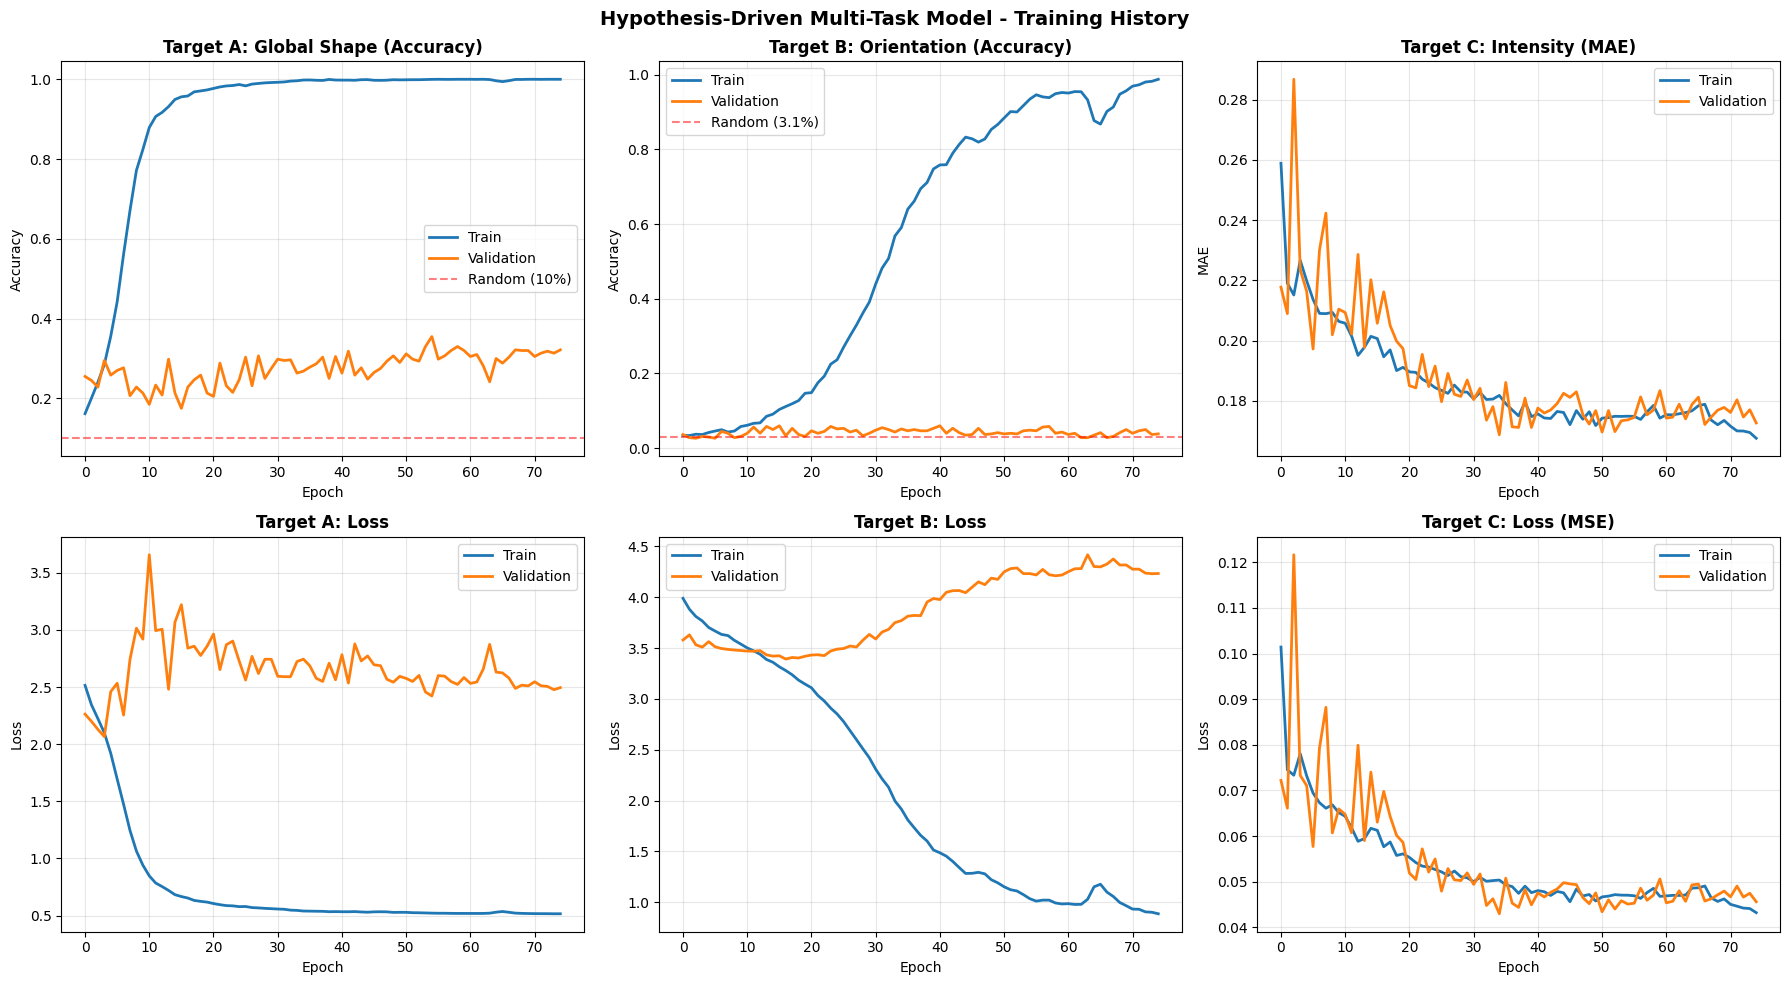


✓ Training completed in 75 epochs
  Best validation - Target A: 35.50%
  Best validation - Target B: 6.00%
  Best validation - Target C: 0.1688 MAE


In [73]:
# Plot training history for MTL model
def plot():
  fig, axes = plt.subplots(2, 3, figsize=(18, 10))
  fig.suptitle('Hypothesis-Driven Multi-Task Model - Training History', fontsize=14, fontweight='bold')

  # Target A - Accuracy
  axes[0, 0].plot(history_mtl.history['output_A_accuracy'], label='Train', linewidth=2)
  axes[0, 0].plot(history_mtl.history['val_output_A_accuracy'], label='Validation', linewidth=2)
  axes[0, 0].axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='Random (10%)')
  axes[0, 0].set_title('Target A: Global Shape (Accuracy)', fontweight='bold')
  axes[0, 0].set_xlabel('Epoch')
  axes[0, 0].set_ylabel('Accuracy')
  axes[0, 0].legend()
  axes[0, 0].grid(True, alpha=0.3)

  # Target A - Loss
  axes[1, 0].plot(history_mtl.history['output_A_loss'], label='Train', linewidth=2)
  axes[1, 0].plot(history_mtl.history['val_output_A_loss'], label='Validation', linewidth=2)
  axes[1, 0].set_title('Target A: Loss', fontweight='bold')
  axes[1, 0].set_xlabel('Epoch')
  axes[1, 0].set_ylabel('Loss')
  axes[1, 0].legend()
  axes[1, 0].grid(True, alpha=0.3)

  # Target B - Accuracy
  axes[0, 1].plot(history_mtl.history['output_B_accuracy'], label='Train', linewidth=2)
  axes[0, 1].plot(history_mtl.history['val_output_B_accuracy'], label='Validation', linewidth=2)
  axes[0, 1].axhline(y=1/32, color='r', linestyle='--', alpha=0.5, label='Random (3.1%)')
  axes[0, 1].set_title('Target B: Orientation (Accuracy)', fontweight='bold')
  axes[0, 1].set_xlabel('Epoch')
  axes[0, 1].set_ylabel('Accuracy')
  axes[0, 1].legend()
  axes[0, 1].grid(True, alpha=0.3)

  # Target B - Loss
  axes[1, 1].plot(history_mtl.history['output_B_loss'], label='Train', linewidth=2)
  axes[1, 1].plot(history_mtl.history['val_output_B_loss'], label='Validation', linewidth=2)
  axes[1, 1].set_title('Target B: Loss', fontweight='bold')
  axes[1, 1].set_xlabel('Epoch')
  axes[1, 1].set_ylabel('Loss')
  axes[1, 1].legend()
  axes[1, 1].grid(True, alpha=0.3)

  # Target C - MAE
  axes[0, 2].plot(history_mtl.history['output_C_mae'], label='Train', linewidth=2)
  axes[0, 2].plot(history_mtl.history['val_output_C_mae'], label='Validation', linewidth=2)
  axes[0, 2].set_title('Target C: Intensity (MAE)', fontweight='bold')
  axes[0, 2].set_xlabel('Epoch')
  axes[0, 2].set_ylabel('MAE')
  axes[0, 2].legend()
  axes[0, 2].grid(True, alpha=0.3)

  # Target C - Loss (MSE)
  axes[1, 2].plot(history_mtl.history['output_C_loss'], label='Train', linewidth=2)
  axes[1, 2].plot(history_mtl.history['val_output_C_loss'], label='Validation', linewidth=2)
  axes[1, 2].set_title('Target C: Loss (MSE)', fontweight='bold')
  axes[1, 2].set_xlabel('Epoch')
  axes[1, 2].set_ylabel('Loss')
  axes[1, 2].legend()
  axes[1, 2].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

  print(f"\n✓ Training completed in {len(history_mtl.history['loss'])} epochs")
  print(f"  Best validation - Target A: {max(history_mtl.history['val_output_A_accuracy'])*100:.2f}%")
  print(f"  Best validation - Target B: {max(history_mtl.history['val_output_B_accuracy'])*100:.2f}%")
  print(f"  Best validation - Target C: {min(history_mtl.history['val_output_C_mae']):.4f} MAE")

plot()

In [74]:
outliers_confident_wrong = df_B[
    (~df_B["correct"]) & (df_B["confidence"] > 0.8)
].sort_values("confidence", ascending=False)

outliers_confident_wrong.head(20)

,index,B_true,B_pred,confidence,correct


In [75]:
unique, counts = np.unique(y_B_train, return_counts=True)
pd.DataFrame({
    "class": unique,
    "count": counts,
    "ratio": counts / counts.sum()
}).sort_values("count")


,class,count,ratio
6,6.0,62,0.025833
2,2.0,63,0.026250
29,29.0,64,0.026667
14,14.0,65,0.027083
10,10.0,65,0.027083
15,15.0,69,0.028750
4,4.0,70,0.029167
21,21.0,70,0.029167
11,11.0,71,0.029583
25,25.0,72,0.030000
